# Método de suavizado exponencial
Permite hacer pronósticos mediante "promedios ponderado que da más peso a lo reciente"

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot, seaborn as sns

In [2]:
ts1 = pd.read_csv('/content/2.1_suav_exp.txt', sep = '\t', usecols=['Zt'])
ts2 = pd.read_csv('/content/2.2_suav_exp.txt', sep = '\t', usecols=['Zt'])
ts3 = pd.read_csv('/content/2.3_suav_exp.txt', sep = '\t', usecols=['Zt'])
ts4 = pd.read_csv('/content/2.4_suav_exp.txt', sep = '\t', usecols=['Zt'])
ts5 = pd.read_csv('/content/2.5_suav_exp.txt', sep = '\t', usecols=['Zt'])
ts6 = pd.read_csv('/content/2.6_suav_exp.txt', sep = '\t', usecols=['Zt'])

## Localmente constantes

### 1. Medias móviles

Descompone la serie de tiempo a partir de un promedio de r observaciones consecutivo

In [8]:
def const_mm(ts, r, t_p = None, alpha = 0.05):
  import pandas as pd
  ts['Mt'] = ts.rolling(r).mean()
  ts['Zt-1'] = ts['Mt'].shift(1)
  ts['S'] = ts['Zt'] - ts['Zt-1']
  ts['at'] = ts['Zt'] - ts['Mt']

  if t_p != None:   # Pronóstico para t = t_p
    import numpy as np, scipy.stats as st
    M_t = ts['Mt'].values[-1]   # Último valor de media móvil
    # Nota: pandas hace varianza muestral, numpy la poblacional
    var = ts['at'].var()
    Z = st.norm.ppf(1-alpha/2)
    xd = Z*(var/r)**0.5
    print(f'IC[t = {t_p}] = [{M_t - xd:.4f}; {M_t + xd:.4f}]')  # [Zt-1 - A, Zt-1 + A]

  return print('Suavización completa')

In [9]:
# Pronóstico para t = 45
const_mm(ts1, r = 3, t_p = 45) 

IC[t = 45] = [51.8149; 54.0851]
Suavización completa


In [10]:
ts1.head(5)

,Zt,Mt,Zt-1,S,at
0,50.05,NaN,NaN,NaN,NaN
1,48.10,NaN,NaN,NaN,NaN
2,50.15,49.433333,NaN,NaN,0.716667
3,51.20,49.816667,49.433333,1.766667,1.383333
4,49.25,50.200000,49.816667,-0.566667,-0.950000


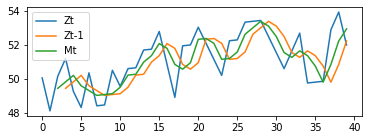

In [12]:
ts1[['Zt', 'Zt-1', 'Mt']].plot(figsize = (6,2))

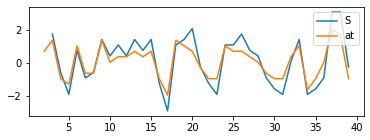

In [13]:
ts1[['S', 'at']].plot(figsize = (6,2))

### 2. Exponencial simple
Pondera la observación actual con el anterior bajo un eso "alpha"

In [14]:
ts2.head(3)

,Zt
0,106.7
1,78.8
2,81.0


In [15]:
def const_ses(ts, alpha, t_p = None, a = 0.05):
  import pandas as pd
  ts['Zt_est'] = ts['Zt']
  
  for i in range(1,len(ts['Zt'])):
    ts['Zt_est'][i] = alpha*ts['Zt'][i] + (1-alpha)*ts['Zt_est'][i-1]

  ts['residual'] = ts['Zt'] - ts['Zt_est']

  if t_p != None:
    import numpy as np, scipy.stats as st
    M_t = ts['Zt_est'].values[-1]
    var = ts['residual'].var() 
    Z = st.norm.ppf(1-a/2)
    xd = Z*(alpha*var/(2-alpha))**0.5
    print(f'IC[t = {t_p}] = [{M_t - xd:.4f}; {M_t + xd:.4f}]')    

const_ses(ts2, alpha = 0.3, t_p = 66)

IC[t = 66] = [94.8721; 106.8895]


In [16]:
ts2.head(5)

,Zt,Zt_est,residual
0,106.7,106.70000,0.00000
1,78.8,98.33000,-19.53000
2,81.0,93.13100,-12.13100
3,76.5,88.14170,-11.64170
4,87.7,88.00919,-0.30919


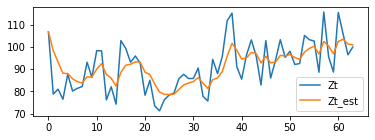

In [18]:
ts2[['Zt', 'Zt_est']].plot(figsize = (6,2))

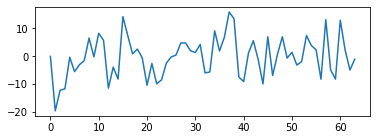

In [19]:
ts2['residual'].plot(figsize = (6,2))

## Con tendencias

### Lineal de Brown

In [20]:
ts3.head(5)

,Zt
0,23.8
1,17.9
2,34.0
3,28.0
4,29.5


In [21]:
def t_lbrown(ts, alpha, t_p = None, S = True):
  import pandas as pd, numpy as np
  ts['Zt_1'] = ts['Zt']     # Primera exponencial simple
  for i in range(1,len(ts['Zt'])):
    ts['Zt_1'][i] = alpha*ts['Zt'][i] + (1-alpha)*ts['Zt_1'][i-1]
    
  ts['Zt_2'] = ts['Zt_1']   # Segunda exponencial simple
  for i in range(1,len(ts['Zt'])):
    ts['Zt_2'][i] = alpha*ts['Zt_1'][i] + (1-alpha)*ts['Zt_2'][i-1]
  
  ts['b1'] = 2*ts['Zt_1'] - ts['Zt_2']
  ts['b2'] = (alpha/(1-alpha))*(ts['Zt_1'] - ts['Zt_2'])

  if t_p != None:
    h = t_p - ts['b1'].index.values[-1]-1
    pro = ts['b1'].values[-1] + h*ts['b2'].values[-1]
    print(f'Z[t = {t_p}] = {pro:.4f}')
  
  if S == True:
    ts['Z(1)'] = 0.0
    for i in range(1,len(ts['Zt'])):
      ts['Z(1)'][i] = ts['b1'][i-1] + ts['b2'][i-1]
    ts['res'] = ts['Zt'] - ts['Z(1)']
    ts['res'][0] = 0.0
    S = np.sum(ts['res']**2)    # Error cuadrático (creo)
    print(f'S = {S}\nRecordar: mejor alpha produce menor S')

t_lbrown(ts3, alpha = 0.3, t_p = 83)

Z[t = 83] = 190.8586
S = 14580.074734501359
Recordar: mejor alpha produce menor S


In [ ]:
ts3.head(5)

,Zt,Zt_1,Zt_2,b1,b2,Z(1),res
0,23.8,23.80000,23.800000,23.800000,0.000000,0.0000,0.0000
1,17.9,22.03000,23.269000,20.791000,-0.531000,23.8000,-5.9000
2,34.0,25.62100,23.974600,27.267400,0.705600,20.2600,13.7400
3,28.0,26.33470,24.682630,27.986770,0.708030,27.9730,0.0270
4,29.5,27.28429,25.463128,29.105452,0.780498,28.6948,0.8052


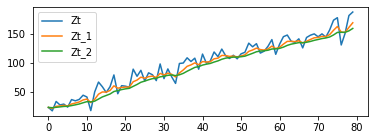

In [23]:
ts3[['Zt', 'Zt_1', 'Zt_2']].plot(figsize = (6,2))

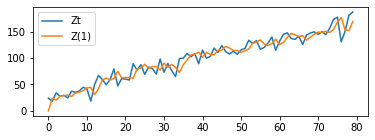

In [25]:
ts3[['Zt', 'Z(1)']].plot(figsize = (6,2))


### Biparamétrica de Holt

In [ ]:
ts4.head(5)

,Zt
0,144.2
1,153.4
2,145.6
3,152.8
4,149.0


In [ ]:
def t_bholt(ts, A, C, t_p = None, alpha = 0.05, S = True):
  import pandas as pd, numpy as np
  ts['Zt_'] = 0.0; ts['Tt'] = 0.0; ts['Zt-1(1)'] = 0.0
  ts['Tt'][1] = ts['Zt'][1] - ts['Zt'][0]
  ts['Zt_'][1] = ts['Zt'][1]

  for i in range(2,len(ts['Zt'])):
    ts['Zt_'][i] = A*ts['Zt'][i] + (1-A)*(ts['Zt_'][i-1] + ts['Tt'][i-1])
    ts['Tt'][i] = C*(ts['Zt_'][i]-ts['Zt_'][i-1]) + (1-C)*ts['Tt'][i-1]
    ts['Zt-1(1)'][i] = ts['Zt_'][i-1] + ts['Tt'][i-1]
  ts['res'] = ts['Zt'] - ts['Zt-1(1)']
  ts['res'][[0,1]] = 0.

  if t_p != None:
    h = t_p - ts['Zt_'].index.values[-1]-1
    pro = ts['Zt_'].values[-1] + h*ts['Tt'].values[-1]
    print(f'Z[t = {t_p}] = {pro:.4f}')

  if S == True:
    S = np.sum(ts['res']**2)
    print(f'S = {S:.4f}\nRecordar: mejor A y C produce menor S')

t_bholt(ts4, A = 0.4, C = 0.8, t_p = 68)

Z[t = 68] = 93.1852
S = 4441.4106


In [ ]:
ts4.head(5)

,Zt,Zt_,Tt,Zt-1(1),res
0,144.2,0.00000,0.000000,0.0000,0.0000
1,153.4,153.40000,9.200000,0.0000,0.0000
2,145.6,155.80000,3.760000,162.6000,-17.0000
3,152.8,156.85600,1.596800,159.5600,-6.7600
4,149.0,154.67168,-1.428096,158.4528,-9.4528


### Cuadrática de Brown

In [ ]:
ts5.head(5)

,Zt
0,437.9
1,415.6
2,416.1
3,425.4
4,436.5


In [ ]:
def t_cbrown(ts, alpha, t_p = None, S = True):
  import pandas as pd, numpy as np

  ts['Zt_1'] = ts['Zt']
  for i in range(1,len(ts['Zt'])):
    ts['Zt_1'][i] = alpha*ts['Zt'][i] + (1-alpha)*ts['Zt_1'][i-1]
    
  ts['Zt_2'] = ts['Zt_1']
  for i in range(1,len(ts['Zt'])):
    ts['Zt_2'][i] = alpha*ts['Zt_1'][i] + (1-alpha)*ts['Zt_2'][i-1]

  ts['Zt_3'] = ts['Zt_2']
  for i in range(1,len(ts['Zt'])):
    ts['Zt_3'][i] = alpha*ts['Zt_2'][i] + (1-alpha)*ts['Zt_3'][i-1]

  ts['b1'] = 0.; ts['b2'] = 0.; ts['b3'] = 0.

  ts['b1'] = 3*(ts['Zt_1'] - ts['Zt_2']) + ts['Zt_3']
  ts['b2'] = (alpha/(2*(1-alpha)**2))*((6-5*alpha)*ts['Zt_1'] - 2*(5-4*alpha)*ts['Zt_2'] + (4-3*alpha)*ts['Zt_3'])
  ts['b3'] = (alpha/(1-alpha))**2*(ts['Zt_1'] - 2*ts['Zt_2'] + ts['Zt_3'])

  ts['b2'][0] = 0.; ts['b3'][0] = 0.

  if t_p != None:
    h = t_p - ts['b1'].index.values[-1]-1
    pro = ts['b1'].values[-1] + h*ts['b2'].values[-1] + h**2*ts['b3'].values[-1]
    print(f'Z[t = {t_p}] = {pro:.4f}')

  if S == True:
    ts['Zt-1(1)'] = 0.0
    for i in range(1,len(ts['Zt'])):
      ts['Zt-1(1)'][i] = ts['b1'][i-1] + ts['b2'][i-1] + ts['b3'][i-1]
    ts['res'] = ts['Zt'] - ts['Zt-1(1)']
    ts['res'][0] = 0.0
    S = np.sum(ts['res']**2)
    print(f'S = {S:.4f}')

t_cbrown(ts5, alpha = 0.2, t_p = 88)

Z[t = 88] = 190.1070
S = 34557.3987
Recordar: mejor alpha produce menor S


In [ ]:
ts5.head(5)

,Zt,Zt_1,Zt_2,Zt_3,b1,b2,b3
0,437.9,437.90000,437.900000,437.900000,437.900000,0.000000,0.000000
1,415.6,433.44000,437.008000,437.721600,427.017600,-2.408400,-0.178400
2,416.1,429.97200,435.600800,437.297440,420.411040,-3.496160,-0.245760
3,425.4,429.05760,434.292160,436.696384,420.992704,-2.812256,-0.176896
4,436.5,430.54608,433.542944,436.065696,427.075104,-1.001088,-0.029632


## Con estacionalidad

### Holt Winters - multiplicativo


In [ ]:
ts5.head(5)

,Zt
0,437.9
1,415.6
2,416.1
3,425.4
4,436.5


In [ ]:
def s_hw_mult(ts, A, C, D, t_p = None, RMSE = True):
  import pandas as pd, numpy as np
  ts['m'] = [x for x in range(1,13)]*int((len(ts['Zt'])+1)/12)
  y = []
  for i in range(1,int((len(ts['Zt'])+1)/12)+1):
    a = [i]*12; y += a 
  ts['y'] = y; ts['Ft'] = 0.; ts['Zt_'] = 0.; ts['Tt'] = 0.

  # Año 1
  s1 = ts['Zt'][0:12].mean()
  ts['Ft'][:12] = ts['Zt'][:12]/s1; ts['Zt_'][11] = s1

  # Demás años
  for i in range(12,len(ts['Zt'])):
    ts['Zt_'][i] = A*(ts['Zt'][i]/ts['Ft'][i-12]) + (1-A)*(ts['Zt_'][i-1] + ts['Tt'][i-1])
    ts['Ft'][i] = D*(ts['Zt'][i]/ts['Zt_'][i]) + (1-D)*ts['Ft'][i-12]
    ts['Tt'][i] = C*(ts['Zt_'][i] - ts['Zt_'][i-1]) + (1-C)*ts['Tt'][i-1]

  if t_p != None:
    h = t_p - ts['Zt_'].index.values[-1]-1
    Ft_last = ts[ts['y']==ts['y'].unique()[-1]]['Ft']
    h_s = h
    while h_s >= 12:
      h_s -=12 

    pro = (ts['Zt_'].values[-1] + h*ts['Tt'].values[-1])*Ft_last.iloc[h_s-1]
    print(f'Z[t = {t_p}] = {pro:.4f}')

  if RMSE == True:
    ts['Z(1)'] = 0.
    for i in range(12,len(ts['Zt'])):
      ts['Z(1)'][i] = (ts['Zt_'][i-1] + ts['Tt'][i-1])*ts['Ft'][i-12]
    ts['res'] = ts['Zt'] - ts['Z(1)']
    ts['res'][:12] = np.nan
    S = np.sum(ts['res']**2)
    RMSE = (S/ts['res'].count())**0.5
    print(f'S = {S:.4f}\nRMSE = {RMSE:.4f}')


s_hw_mult(ts5, A = 0.4, C = 0.8, D = 0.1, t_p=115)
# No preocuparse por las letras de las salidas

Z[t = 115] = 107.5926
S = 62157.5781
RMSE = 29.3820


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_

In [ ]:
ts5.head(5)

,Zt,m,y,Ft,Zt_,Tt,Z(1),res
0,437.9,1,1,1.016796,0.0,0.0,0.0,NaN
1,415.6,2,1,0.965015,0.0,0.0,0.0,NaN
2,416.1,3,1,0.966176,0.0,0.0,0.0,NaN
3,425.4,4,1,0.987771,0.0,0.0,0.0,NaN
4,436.5,5,1,1.013545,0.0,0.0,0.0,NaN


### Holt Winters - aditivo


In [ ]:
ts6.head(5)

,Zt
0,211.1
1,229.9
2,284.8
3,212.6
4,186.0


In [ ]:
def s_hw_adit(ts, A, C, D, t_p = None, RMSE = True): # Nota: falta generalizar para s cualquiera, ahorita asumimos s=12 (12 meses)
  import pandas as pd, numpy as np
  ts['m'] = [x for x in range(1,13)]*int((len(ts['Zt'])+1)/12)
  y = []
  for i in range(1,int((len(ts['Zt'])+1)/12)+1):
    a = [i]*12; y += a 
  ts['y'] = y; ts['Ft'] = 0.; ts['Zt_'] = 0.; ts['Tt'] = 0.

  # Año 1
  s1 = ts['Zt'][0:12].mean()
  ts['Ft'][:12] = ts['Zt'][:12]-s1; ts['Zt_'][11] = s1

  # Demás años
  for i in range(12,len(ts['Zt'])):
    ts['Zt_'][i] = A*(ts['Zt'][i] - ts['Ft'][i-12]) + (1-A)*(ts['Zt_'][i-1] + ts['Tt'][i-1])
    ts['Ft'][i] = D*(ts['Zt'][i] - ts['Zt_'][i]) + (1-D)*ts['Ft'][i-12]
    ts['Tt'][i] = C*(ts['Zt_'][i] - ts['Zt_'][i-1]) + (1-C)*ts['Tt'][i-1]

  if t_p != None:
    h = t_p - ts['Zt_'].index.values[-1]-1
    Ft_last = ts[ts['y']==ts['y'].unique()[-1]]['Ft']
    h_s = h
    while h_s >= 12:
      h_s -=12 

    pro = ts['Zt_'].values[-1] + h*ts['Tt'].values[-1] + Ft_last.iloc[h_s-1]
    print(f'Z[t = {t_p}] = {pro:.4f}')

  if RMSE == True:
    ts['Z(1)'] = 0.
    for i in range(12,len(ts['Zt'])):
      ts['Z(1)'][i] = ts['Zt_'][i-1] + ts['Tt'][i-1] + ts['Ft'][i-12]
    ts['res'] = ts['Zt'] - ts['Z(1)']
    ts['res'][:12] = np.nan
    S = np.sum(ts['res']**2)
    RMSE = (S/ts['res'].count())**0.5
    print(f'S = {S:.4f}\nRMSE = {RMSE:.4f}')

s_hw_adit(ts6, A = 0.2, C = 0.4, D = 0.8)
# No preocuparse por las letras de las salidas

S = 48547.2381
RMSE = 28.4450


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_

In [ ]:
ts6.head(16)

,Zt,m,y,Ft,Zt_,Tt,Z(1),res
0,211.1,1,1,48.666667,0.000000,0.000000,0.00000,NaN
1,229.9,2,1,67.466667,0.000000,0.000000,0.00000,NaN
2,284.8,3,1,122.366667,0.000000,0.000000,0.00000,NaN
3,212.6,4,1,50.166667,0.000000,0.000000,0.00000,NaN
4,186.0,5,1,23.566667,0.000000,0.000000,0.00000,NaN
5,153.8,6,1,-8.633333,0.000000,0.000000,0.00000,NaN
6,104.8,7,1,-57.633333,0.000000,0.000000,0.00000,NaN
7,62.6,8,1,-99.833333,0.000000,0.000000,0.00000,NaN
8,80.8,9,1,-81.633333,0.000000,0.000000,0.00000,NaN
9,77.3,10,1,-85.133333,0.000000,0.000000,0.00000,NaN
